In [1]:
%matplotlib inline
from IPython.core.pylabtools import figsize
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pandas as pd
import pymc as pm

WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


[115.85679142 152.26153716 178.87449059 162.93500815 107.02820697
 105.19141146 118.38288501 125.3769803  102.88054011 206.71326136] ...


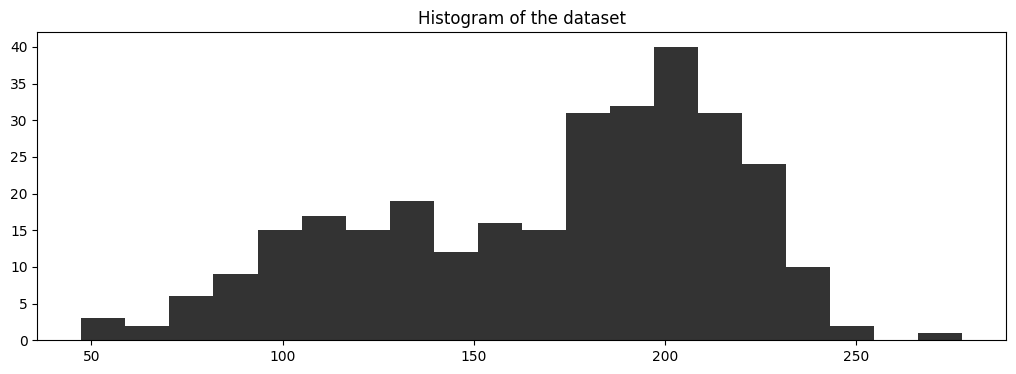

In [2]:

figsize(12.5, 4)
data = np.loadtxt("data/mixture_data.csv", delimiter=",")

plt.hist(data, bins=20, color="k", histtype="stepfilled", alpha=0.8)
plt.title("Histogram of the dataset")
plt.ylim([0, None]);
print(data[:10], "...")

In [3]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0, 1)
    p2 = 1 - p1
    assignment = pm.Categorical(
        "assignment", 
        [p1, p2], 
        shape=data.shape[0])
    


In [4]:
with model:
    print(pm.draw(assignment))

[0 0 0 0 0 0 1 0 1 0 1 0 0 1 0 1 0 0 1 0 0 1 1 0 0 1 1 0 0 1 1 1 1 1 1 1 0
 0 1 1 1 0 0 1 1 0 0 1 0 1 1 1 0 0 0 0 1 1 1 1 1 0 0 0 0 0 0 1 0 0 0 1 0 0
 0 1 0 0 1 0 1 0 1 1 0 0 0 0 1 1 0 0 0 0 0 1 0 0 0 1 1 0 1 0 0 1 1 1 1 0 0
 1 0 0 1 0 0 0 1 0 0 1 0 1 0 0 0 0 1 0 1 1 1 1 1 1 0 1 1 0 1 0 0 1 0 0 0 1
 0 1 1 0 0 1 1 1 1 0 0 1 1 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 1 0 0 0 1 1 0 0
 0 0 0 0 0 1 1 1 1 0 0 1 1 0 1 1 0 0 0 0 0 0 0 0 1 0 0 1 0 0 0 0 0 0 0 1 1
 1 1 0 0 1 0 1 1 0 0 1 1 0 0 0 0 0 0 1 0 1 1 0 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 0 1 0 0 0 0 1 1 1 1 0 0 0 0 0 0 1 0 0 1 0 0 0 1 1 1 0 0 0 0 1 1 1 0 0 0
 0 1 1 0]


In [5]:
with model:
    centers = pm.Normal("centers", 
                        mu=np.array([120, 190]), 
                        sigma=np.array([10, 10]), 
                        shape=2)
    sigmas = pm.Uniform("sigmas", 0, 100, shape=2)
    
    center_i = pm.Deterministic('center_i', centers[assignment])
    sigma_i = pm.Deterministic('sigma_i', sigmas[assignment])
    
    # and to combine it with the observations:
    observations = pm.Normal("obs", mu=center_i, sigma=sigma_i, observed=data)
    

In [6]:
with model:
    step1=pm.NUTS(vars=[p1, sigmas, centers])
    step2=pm.BinaryGibbsMetropolis(vars=[assignment])
    trace = pm.sample(3000, tune=0, step=[step1, step2], return_inferencedata=False, chains=1)

Sequential sampling (1 chains in 1 job)
CompoundStep
>NUTS: [p, sigmas, centers]
>BinaryGibbsMetropolis: [assignment]


Sampling 1 chain for 0 tune and 3_000 draw iterations (0 + 3_000 draws total) took 87 seconds.
Only one chain was sampled, this makes it impossible to run some convergence checks


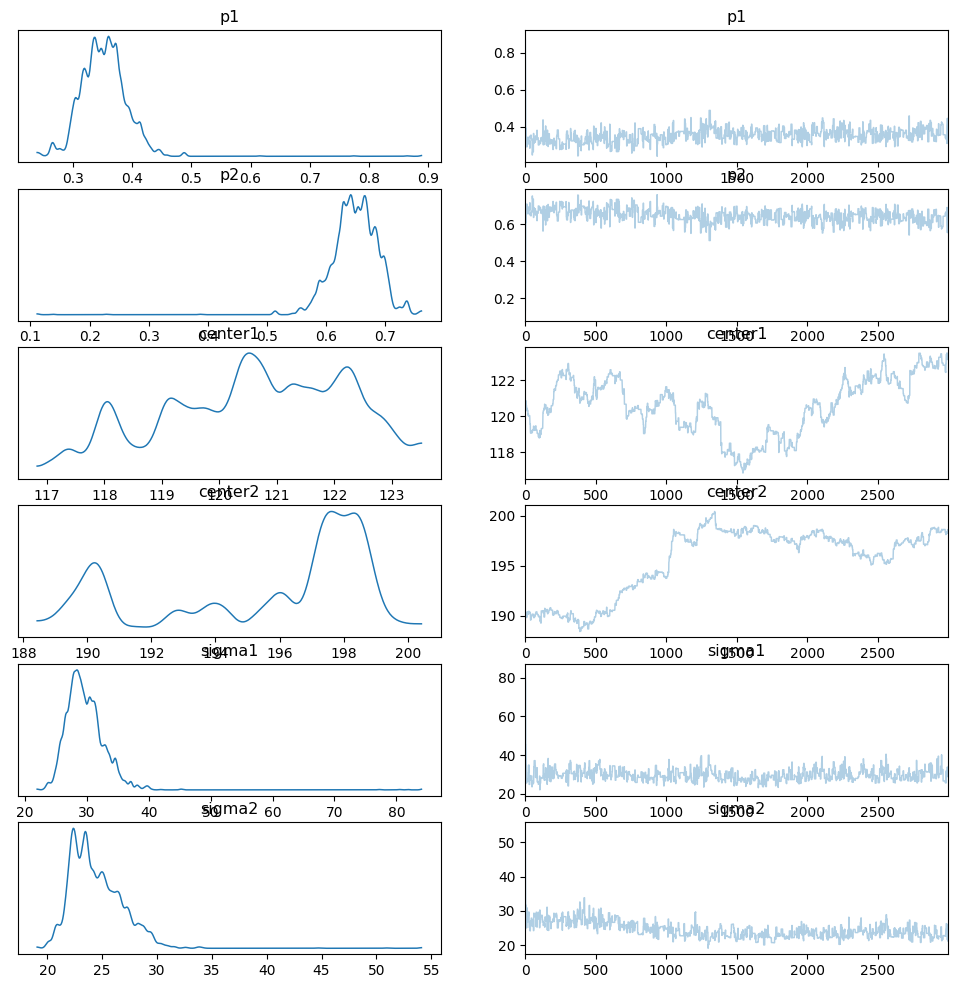

In [13]:
pm.plot_trace({
    "p1": trace['p'],
    "p2": 1-trace['p'],
    "center1": trace["centers"][:,0],
    "center2": trace["centers"][:,1],
    "sigma1": trace["sigmas"][:,0],
    "sigma2": trace["sigmas"][:,1]
    
});

<Axes: title={'center': 'x'}>

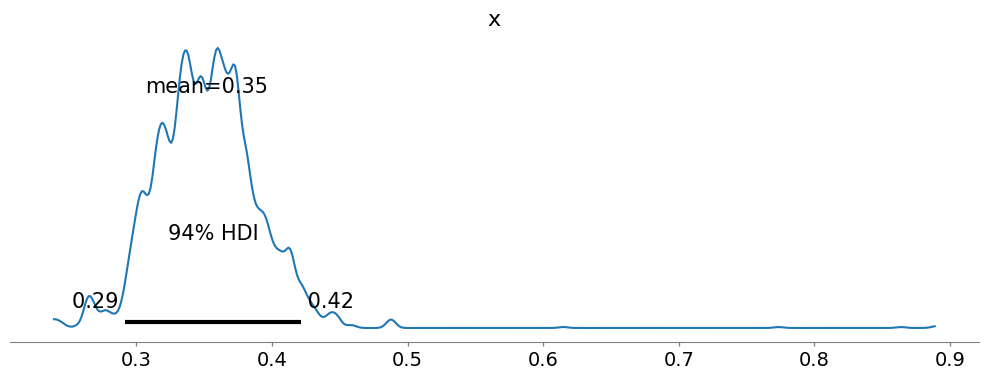

In [15]:
pm.plot_posterior(trace['p'])

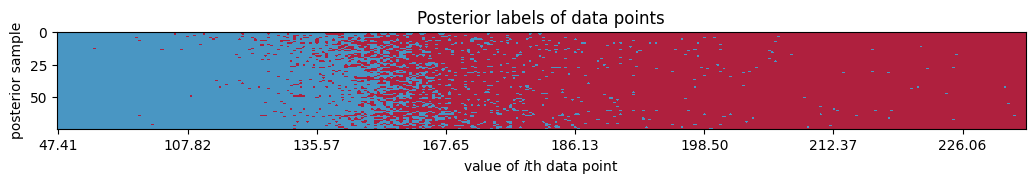

In [16]:
import matplotlib as mpl
figsize(12.5, 4)
colors = ["#348ABD", "#A60628"]
plt.cmap = mpl.colors.ListedColormap(colors)

plt.imshow(trace["assignment"][::40, np.argsort(data)],
       cmap=plt.cmap, aspect=0.4, alpha=.9)
plt.xticks(np.arange(0, data.shape[0], 40),
       ["%.2f" % s for s in np.sort(data)[::40]])
plt.ylabel("posterior sample")
plt.xlabel("value of $i$th data point")
plt.title("Posterior labels of data points");

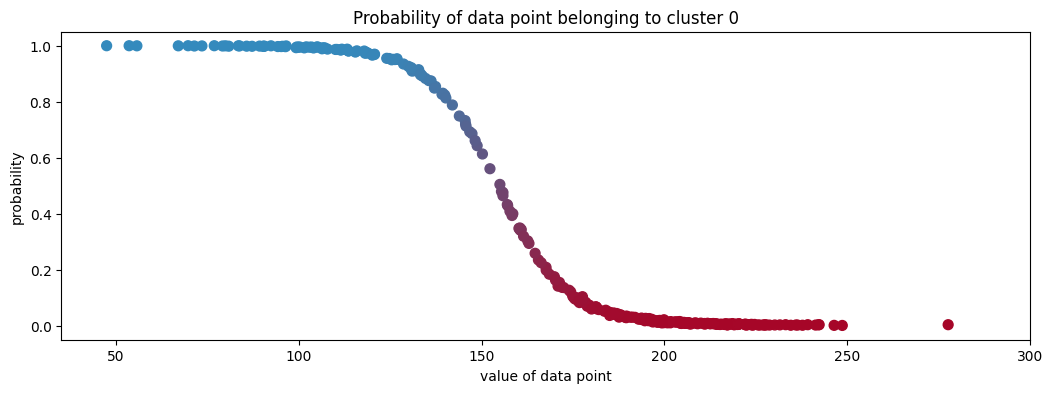

In [17]:
cmap = mpl.colors.LinearSegmentedColormap.from_list("BMH", colors)
assign_trace = trace["assignment"]
plt.scatter(data, 1 - assign_trace.mean(axis=0), cmap=cmap,
        c=assign_trace.mean(axis=0), s=50)
plt.ylim(-0.05, 1.05)
plt.xlim(35, 300)
plt.title("Probability of data point belonging to cluster 0")
plt.ylabel("probability")
plt.xlabel("value of data point");

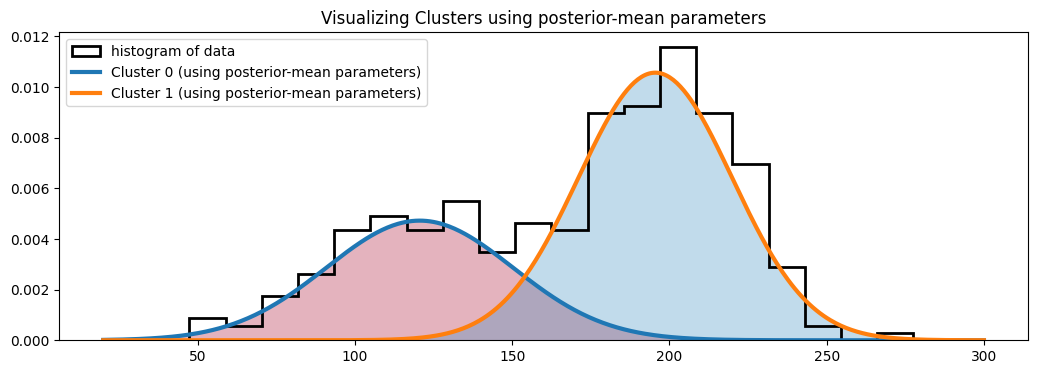

In [18]:
from scipy import stats
norm = stats.norm
x = np.linspace(20, 300, 500)
posterior_center_means = trace['centers'].mean(axis=0)
posterior_std_means = trace['sigmas'].mean(axis=0)
posterior_p_mean = trace["p"].mean()

plt.hist(data, bins=20, histtype="step", density=True, color="k",
     lw=2, label="histogram of data")
y = posterior_p_mean * norm.pdf(x, loc=posterior_center_means[0],
                                scale=posterior_std_means[0])
plt.plot(x, y, label="Cluster 0 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[1], alpha=0.3)

y = (1 - posterior_p_mean) * norm.pdf(x, loc=posterior_center_means[1],
                                      scale=posterior_std_means[1])
plt.plot(x, y, label="Cluster 1 (using posterior-mean parameters)", lw=3)
plt.fill_between(x, y, color=colors[0], alpha=0.3)

plt.legend(loc="upper left")
plt.title("Visualizing Clusters using posterior-mean parameters");

In [12]:
posterior_p_mean

0.35177399577728147